In [1]:
from IPython.display import Image

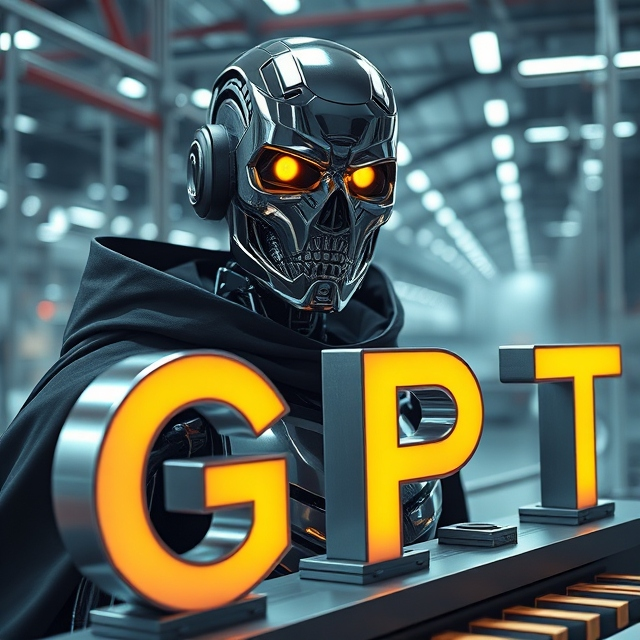

In [2]:
Image(filename = 'RE-GPT.jpeg')

# Reverse Engineering GPT

#### Drawing inspiration from Andrej Karpathy’s iconic lecture, "Let’s Build GPT: From Scratch, in Code, Spelled Out", this project takes you on an immersive journey into the inner workings of GPT. Step-by-step, we’ll construct a GPT model from the ground up, demystifying its architecture and bringing its mechanics to life through hands-on coding.

### [original video from Andrej Karpathy](https://www.youtube.com/watch?v=kCc8FmEb1nY)

#### Credit: [Andrej Karpathy](mailto:karpathy@eurekalabs.ai)
#### Instructor: [Kevin Thomas](mailto:ket189@pitt.edu)

## [Attention Is All You Need](https://arxiv.org/pdf/1706.03762)
#### Academic Paper

In [3]:
!pip install torch

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [5]:
from IPython.display import Image

## Transformer Model Architecture

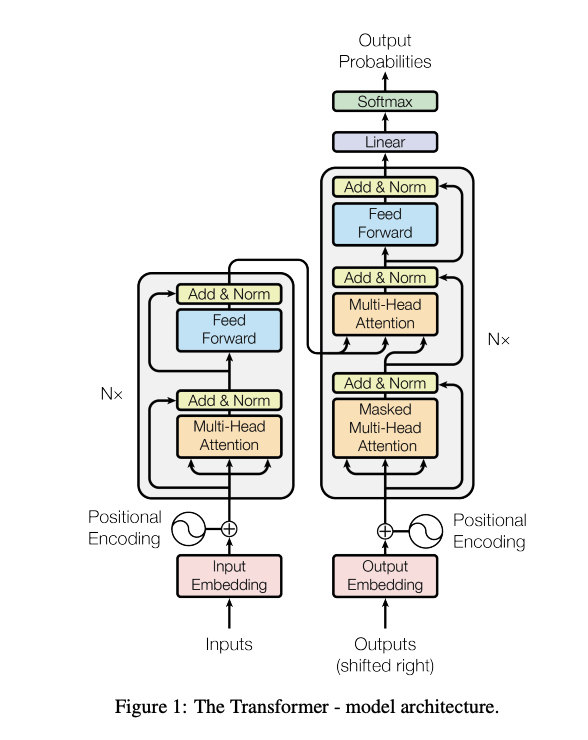

In [6]:
Image(filename = 'transformer-model-arch.png', width=400)

## Understanding Self-Attention in Simple Terms

When building a language model like GPT from scratch, we initially might use a uniform weight matrix `wei` based on a function like `torch.tril`. This matrix treats all previous tokens equally, which isn’t ideal because different words (tokens) in a sentence might be more or less important to each other. For example, if a vowel in a word is looking back at previous letters, it might be more interested in certain consonants rather than all past letters equally.

Self-attention helps solve this problem by allowing each token to focus on specific other tokens in a data-dependent way. Here’s how it works: every token at each position generates two vectors—`query` and `key`. The `query` vector represents **“What am I looking for?”** and the `key` vector represents **“What do I contain?”**. By computing the dot product between a token’s query and the keys of all other tokens, we obtain a measure of similarity or “affinity”. This affinity tells us how much attention one token should pay to another.

In code, we start by initializing linear layers for the keys and queries without biases:
```python
key = nn.Linear(input_size, head_size, bias=False)
query = nn.Linear(input_size, head_size, bias=False)
```

We then compute the keys and queries by passing our input `x` (which contains all tokens) through these layers:
```python
k = key(x)  # shape: (B, T, head_size)
q = query(x)  # shape: (B, T, head_size)
```

Here, `B` is the `batch_size`, `T` is the sequence length, and `head_size` is a hyperparameter (like 16). At this point, each token has independently produced its key and query vectors without any communication with other tokens.

Next, we compute the affinities (similarities) between tokens by taking the dot product of queries and transposed keys:
```python
wei = q @ k.transpose(-2, -1)  # shape: (B, T, T)
```

This results in a matrix where each element tells us how much one token should pay attention to another. For example, `wei[0][8][4]` might represent how much the 8th token in the first batch should focus on the 4th token. These affinities are data-dependent, meaning they change based on the actual content of the tokens.

However, when aggregating information, we don’t use the original tokens directly. Instead, each token also generates a value vector, which represents the information it wants to share:
```python
value = nn.Linear(input_size, head_size, bias=False)
v = value(x)  # shape: (B, T, head_size)
```

Finally, we use the affinities to compute a weighted sum of these values:
```python
output = wei @ v  # shape: (B, T, head_size)
```

This means each token gathers information from other tokens, weighted by how relevant they are (as determined by the affinities). So, a token effectively says, **“Based on what I’m interested in (my query) and what others contain (their keys), here’s the combined information (values) I should consider.”**

By doing this, self-attention allows the model to dynamically focus on different parts of the input sequence, enabling it to capture complex patterns and relationships in the data.

In [7]:
# version 4: self-attention!
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [8]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

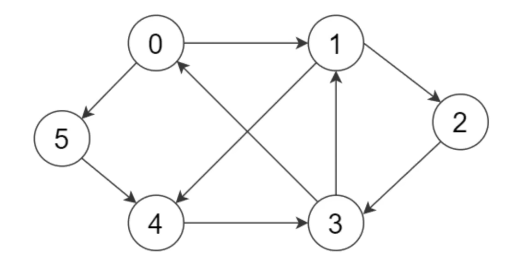

In [9]:
Image(filename = 'attention.png', width=400)

## Understanding Attention Mechanisms in Simple Terms

Attention is like a way for different parts (nodes) of a network to communicate with each other. Imagine these nodes as points in a directed graph where edges show which nodes are connected. Each node has some information stored as a vector, and it can gather information from other nodes it’s connected to by taking a weighted sum of their vectors. The weights are data-dependent, meaning they change based on the actual content at each node.

In our case, we have a graph of 8 nodes because our `block_size` is 8, so there are always 8 tokens. The structure is such that the first node only looks at itself, the second node looks at itself and the first node, and so on, up to the 8th node, which looks at all previous nodes and itself. This setup ensures that future tokens don’t influence past ones, which is important in language modeling where we predict the next word based on previous words.

One important thing to note is that attention doesn’t have a built-in sense of position or space. The nodes don’t inherently know where they are in the sequence. To fix this, we add positional encodings to our input vectors so that each token is aware of its position in the sequence. This is different from convolutional operations where the position is inherently part of the computation due to the structure of the convolution filters.

In our model, we process multiple examples at once using batches. For instance, with a `batch_size` of 4, we have 4 separate groups of 8 nodes. These groups are processed independently and don’t share information with each other. This is handled efficiently using batched matrix multiplications that operate across the batch dimension `B`.

When it comes to the code, if we wanted all the nodes to communicate with each other (like in tasks where future tokens can influence past ones), we’d use an encoder attention block. This involves removing the masking line in our code:
```python
wei = wei.masked_fill(tril == 0, float('-inf'))
```

By deleting this line, we allow every node to attend to every other node without restrictions. However, for language modeling, we keep this line to prevent future tokens from influencing the computation of past tokens, creating what’s known as a **decoder attention block**.

Lastly, in self-attention, the keys, queries, and values all come from the same source `x`. This means each node is attending to other nodes within the same set. In contrast, cross-attention involves keys and values coming from a different source than the queries, which is useful when integrating information from external data or another part of the network.

## Understanding Scaled Attention in Simple Terms

### Scaled Dot-Product Attention Formula

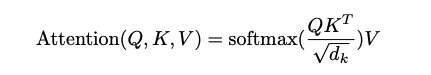

In [10]:
Image(filename = 'scaled-dot-product-attention-formula.png', width=350)

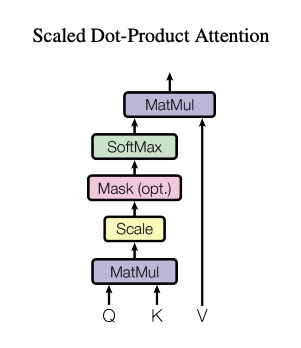

In [11]:
Image(filename = 'scaled-dot-product-attention.png', width=250)

In the **“Attention Is All You Need”** paper, we’ve learned how to implement attention mechanisms using queries, keys, and values. We multiply the queries (`q`) and keys (`k`), apply the softmax function to the result, and then use these weights to aggregate the values (`v`). This process allows the model to focus on different parts of the input data.

However, there’s an important step we haven’t included yet: dividing by the square root of the `head_size` (denoted as dk in the formula). This operation is known as scaled attention, and it’s a crucial normalization step in the attention mechanism.

Here’s why scaling is important: if `q` and `k` are random variables drawn from a standard normal distribution (mean of 0 and standard deviation of 1), then their dot product will have a variance proportional to the `head_size` (which is 16 in our case). Without scaling, the `wei` (weights) would have a variance of about 16, causing the softmax function to produce very sharp (peaked) outputs.

By multiplying by `head_size**-0.5` (which is the same as dividing by the square root of head_size), we adjust the variance of `wei` back to 1:
```python
wei = q @ k.transpose(-2, -1) * head_size ** -0.5
```

This scaling ensures that when we apply the softmax function:
```python
wei = F.softmax(wei, dim=-1)
```

The resulting weights are more evenly distributed (diffuse) rather than being overly concentrated. This is especially important during initialization because it allows the model to explore different parts of the input without being biased toward specific positions.

In summary, including the scaling factor in our attention computation helps maintain stable gradients and prevents the softmax outputs from becoming too extreme. This makes the model more effective at learning and focusing on the relevant parts of the input data.

In [12]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [13]:
k.var()

tensor(1.0449)

In [14]:
q.var()

tensor(1.0700)

In [15]:
wei.var()

tensor(1.0918)

## Understanding the Impact of Softmax in Attention Mechanisms

In our attention mechanism, we use the softmax function to convert the raw attention weights (`wei`) into probabilities that sum up to one. However, there’s a problem when the values inside `wei` are very large or very small (both positive and negative). When `wei` contains very large positive and negative numbers, the softmax function tends to produce outputs that are extremely peaked, meaning it approaches one-hot vectors. This results in the model focusing almost entirely on one token and ignoring the rest, which isn’t always desirable.

For example, if we have `wei` values like `[10, 20, 30]`, applying softmax will give us something close to `[0.0, 0.0, 1.0]`. This happens because the exponential function in softmax amplifies the differences between large numbers, making the largest value dominate the output. Conversely, if we apply softmax to values that are very close to zero, like `[0.1, 0.2, 0.3]`, the output will be more evenly distributed, such as `[0.30, 0.33, 0.37]`. This diffuse output means the model considers multiple tokens more equally.

To prevent the softmax from becoming too sharp and focusing only on one token, we need to ensure that the values in `wei` are not too large in magnitude. This is where scaling comes in. By dividing `wei` by a scaling factor (specifically, the square root of the `head_size`), we reduce the variance of its values, keeping them closer to zero. This scaling ensures that the softmax function produces a more balanced output.

In code, we implement this scaling as follows:
```python
wei = q @ k.transpose(-2, -1) * head_size ** -0.5
```

By including the scaling factor `head_size ** -0.5`, we adjust the attention weights so that their variance is controlled, and the softmax function doesn’t saturate. This allows the model to consider information from multiple tokens rather than just one, improving its ability to learn and generalize from the data.

Understanding this scaling is important because it highlights how mathematical operations in neural networks can significantly impact the model’s performance. By carefully managing the values passed into functions like softmax, we ensure that the attention mechanism works effectively, allowing our GPT model to capture complex patterns in language.

In [16]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [17]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

## Understanding the Head Class in Self-Attention

In our journey to build GPT from scratch, the `Head` class is crucial because it implements a single head of self-attention. Self-attention allows the model to focus on different parts of the input sequence when generating each part of the output, which is essential for understanding context in language.

When we initialize the `Head` class, we pass in a parameter called `head_size`. Inside the constructor (`__init__` method), we create three linear layers: `key`, `query`, and `value`. These layers are initialized without bias terms (`bias=False`) and are used to project our input `x` into different representations:

```python
self.key = nn.Linear(input_size, head_size, bias=False)
self.query = nn.Linear(input_size, head_size, bias=False)
self.value = nn.Linear(input_size, head_size, bias=False)
```

These linear layers apply matrix multiplications to the input data and are essential for computing the attention mechanism.

We also create a lower triangular matrix called tril using `torch.tril`, which stands for “triangle lower.” This matrix is registered as a buffer (not a parameter that the model learns) using register_buffer:
```python
self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
```

This matrix ensures that each position in the sequence can only attend to itself and previous positions, preventing information from “future” tokens from influencing the current token (which is important for language modeling where we predict the next word).

In the forward method, which defines how the data flows through the model, we take an input `x` and extract its dimensions:
```python
B, T, C = x.shape  # Batch size, Sequence length, Embedding size
```

We compute the `key` and `query` matrices by passing`x` through their respective linear layers:
```python
k = self.key(x)  # Shape: (B, T, C)
q = self.query(x)  # Shape: (B, T, C)
```

We calculate the attention weights (wei) by taking the dot product of `q` and the transposed `k`, and then we normalize it by dividing by the square root of `C` (this is known as scaled attention):
```python
wei = q @ k.transpose(-2, -1) * C ** -0.5  # Shape: (B, T, T)
```

To ensure that future tokens do not influence the current token, we apply the lower triangular mask:
```python
wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # Shape: (B, T, T)
```

We then apply the softmax function to turn these weights into probabilities that sum to one:
```python
wei = F.softmax(wei, dim=-1)
```

Next, we compute the value matrix:
```python
v = self.value(x)  # Shape: (B, T, C)
```

Finally, we perform the weighted aggregation of the values by multiplying the attention weights `wei` with the values `v`:
```python
out = wei @ v  # Shape: (B, T, C)
return out
```

The result out is a new representation of the input sequence where each token has gathered information from the relevant tokens that came before it. This mechanism allows the model to capture dependencies and relationships in the data, which is fundamental for tasks like language modeling.

In [18]:
class Head(nn.Module):
    """One head of self-attention."""
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T) 
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) 
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

## Understanding Self-Attention and Positional Embeddings in Our Language Model

In our language model called `BigramLanguageModel`, we incorporate self-attention mechanisms to help the model understand relationships between different tokens in a sequence. Within the constructor of our model, we create multiple attention blocks using the following code:
```python
self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
```

Here, `n_embd` represents the embedding size (the dimensionality of our token embeddings), and `n_head` is the number of attention heads we want to use. Each `Block` is essentially a self-attention head, and we’re stacking them together using `nn.Sequential`. The `head_size` for each attention head is set to `n_embd`.

In the forward method, we first encode our input tokens by adding token embeddings and positional embeddings:
```python
x = tok_emb + pos_emb
```

This means we take the embeddings of the tokens (`tok_emb`) and add positional information (`pos_emb`) so that the model knows the position of each token in the sequence. We then pass this combined embedding `x` through our self-attention blocks:
```python
x = self.blocks(x)
```

The output from the attention blocks is then fed into the language modeling head to produce the `logits`, which are the unnormalized probabilities for the next token in the sequence:
```python
logits = self.lm_head(x)
```

When generating new text with the generate method, we need to ensure that the input indices (`idx`) we feed into the model do not exceed the `block_size`. This is because our positional embedding table only has embeddings up to `block_size`, and we can’t provide positional embeddings for positions beyond that. To handle this, we crop the context to the last `block_size` tokens:
```python
idx_cond = idx[:, -block_size:]
```

By doing this, we make sure we’re always using a valid range of positional embeddings, preventing any errors or out-of-scope issues. This allows the model to generate text effectively while respecting the limitations of our positional embedding setup.

In [19]:
class BigramLanguageModel(nn.Module):
    """Language model based on the Transformer architecture."""
    
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

## Understanding Multi-Head Attention in Simple Terms

### Multi-Head Attention Formula

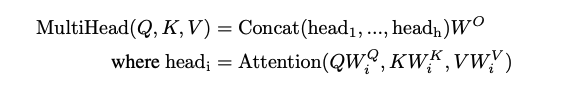

In [20]:
Image(filename = 'multi-head-attention-formula.png', width=450)

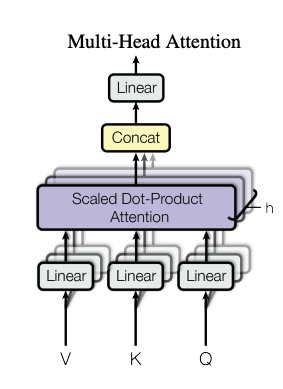

In [21]:
Image(filename = 'multi-head-attention.png', width=200)

In our GPT model built from scratch, we use a concept called **Multi-Head Attention**. This means we have multiple self-attention mechanisms (called “heads”) running in parallel. Instead of relying on a single attention mechanism, we allow the model to focus on different aspects of the input simultaneously.

In PyTorch, we specify the number of heads (`num_heads`) and the size of each head (`head_size`). Here’s how we create multiple heads:
```python
self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
```

Each Head is an instance of our self-attention mechanism. We process the input `x` through all these heads in parallel and then concatenate their outputs along the channel dimension (`dim=-1`):
```python
out = torch.cat([h(x) for h in self.heads], dim=-1)
```

This concatenation combines the outputs of all the attention heads into a single tensor.

Instead of having a single attention head with a `head_size` equal to the embedding size (`n_embd`), we divide the embedding size among multiple heads. For example, if `n_embd` is 32 and we have 4 heads, each head will have a `head_size` of 8. This means:
* We have 4 communication channels (heads) running in parallel.
* Each head processes an 8-dimensional vector.
* When we concatenate the outputs of all heads, we get back to the original embedding size of 32.

Having multiple attention heads is beneficial because tokens (like words or characters) have a lot of different things to “talk” about. For instance, they might want to find vowels, consonants, or specific patterns at certain positions. By using multiple independent channels of communication, each head can focus on different types of information. This allows the model to gather a richer set of data before making predictions, leading to better performance in understanding and generating language.

In [22]:
class MultiHeadAttention(nn.Module):
    """Multiple self-attention heads in parallel."""
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

## Adding Computation at the Token Level

### Position-Wise Feed-Forward Network Formula

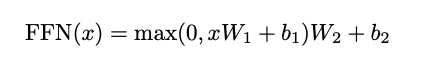

In [23]:
Image(filename = 'ffn-formula.png', width=350)

So far in our language model, we’ve implemented multi-headed self-attention, which allows tokens (like words or characters) to communicate with each other. This means each token can look at other tokens in the sequence and gather information from them. However, we’ve been moving a bit too quickly from this communication step to making predictions (calculating the `logits`) in our `BigramLanguageModel`.

The problem is that while the tokens have looked at each other, they haven’t had much time to process or “think about” the information they’ve gathered from other tokens. To fix this, we’re going to add a small feed-forward neural network that operates on a per-token level. This means that after gathering information, each token will independently process that information to make better predictions.

This feed-forward network is simply a linear layer followed by a ReLU (Rectified Linear Unit) activation function, which introduces non-linearity. In code, we implement it like this within our `Block` class:
```python
self.ffwd = FeedForward(n_embd)
```

And we call it right after the self-attention layer in the forward method. The FeedForward class might look something like this:
```python
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)
```

Here, `n_embd` is the embedding size (the size of our token vectors). Each token processes its own vector independently through this network. The self-attention layer allows tokens to gather information from others (communication), and the feed-forward network allows each token to process that information individually (computation).

By adding this computation step, we enable each token to make better use of the information it has received, leading to improved performance of the language model. This mirrors how, in human communication, we not only listen to others but also take time to think and process what we’ve heard before responding.

In [24]:
class FeedFoward(nn.Module):
    """A simple feed-forward neural network."""
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

## Understanding Transformer Blocks and Their Role in GPT

In building our GPT (Generative Pre-trained Transformer) model from scratch, we’re now focusing on combining communication and computation within the network. This approach mirrors how Transformers work—they have blocks that allow tokens (like words or characters) to communicate with each other and then compute based on that information. These blocks are grouped and replicated multiple times to build a powerful model.

The core of this mechanism is implemented in the `Block` class, which represents the main part of the Transformer decoder model (excluding cross-attention components that interact with an encoder in some architectures). The `Block` class interleaves communication and computation steps. The communication is handled by multi-headed self-attention:
```python
self.sa = MultiHeadAttention(n_head, head_size)
```

This allows tokens to look at other tokens in the sequence and gather relevant information. After communication, each token independently processes the gathered information using a feed-forward neural network:
```python
self.ffwd = FeedForward(n_embd)
```

In the constructor of the `Block` class, we specify `n_embd`, which is the size of our token embeddings (the embedding dimension), and `n_head`, the number of attention heads we want to use. These parameters determine how the tokens will communicate and compute within each block.

Within our `BigramLanguageModel` class, we stack these blocks sequentially to build the depth of the model:
```python
self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
```

Here, `n_layer` specifies how many times we repeat the `Block`. This setup allows us to interleave communication and computation multiple times, enabling the model to capture complex patterns in language. Finally, in the forward method, after passing the data through all the blocks, we decode the output to generate the logits (the raw predictions before applying softmax) using:
```python
logits = self.lm_head(x)
```

By interspersing communication and computation in this way, each token can gather information from others and then process it independently, which is crucial for understanding context and generating coherent text in language models like GPT.

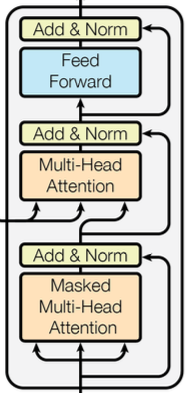

In [25]:
Image(filename = 'block.png', width=120)

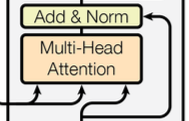

In [26]:
Image(filename = 'cross-attention.png', width=125)

In [27]:
class Block(nn.Module):
    """Transformer block: communication followed by computation."""
    
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

## Improving Deep Neural Networks with Residual Connections

At this stage of building our GPT model from scratch, we’re noticing that the performance isn’t as good as we’d like. One reason is that our neural network is becoming quite deep, and deep neural networks often face optimization issues. This means they can be hard to train effectively because the gradients used in learning can either vanish or explode as they pass through many layers.

To tackle this problem, we can borrow an idea from the **“Attention Is All You Need”** paper. The paper introduces two optimizations that significantly help deep networks remain trainable. The first optimization is the use of skip connections, also known as residual connections. These connections allow the model to bypass certain layers by adding the input of a layer directly to its output. This helps preserve the original information and makes it easier for the network to learn.

In simple terms, instead of just passing data through a transformation (like a neural network layer), we also add the original data back into the output. This means that if the transformation doesn’t learn anything useful, the network can still pass the original information forward. This helps prevent the network from getting worse as it gets deeper.

Here’s how we can implement residual connections in our `Block` class:
```python
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = x + self.sa(x)    # residual connection after self-attention
        x = x + self.ffwd(x)  # residual connection after feed-forward network
        return x
```

In this code:
* Self-Attention Residual Connection: We compute `self.sa(x)`, which is the output of the self-attention layer, and add it to the original input `x`.
```python
x = x + self.sa(x)
```
* Feed-Forward Residual Connection: Similarly, we compute `self.ffwd(x)`, which processes each token independently, and add it to the result of the previous step.
```python
x = x + self.ffwd(x)
```

By adding these residual connections, we’re effectively allowing the network to “skip” layers if needed, making it easier to train deeper models. The residual connections help the gradients flow backward through the network during training, which addresses the optimization issues associated with deep neural networks.

In summary, residual connections are a simple yet powerful idea that helps deep neural networks learn more effectively. By incorporating them into our model, we’re borrowing a successful strategy from advanced architectures like Transformers, ensuring that our GPT model can train successfully even as it becomes deeper and more complex.

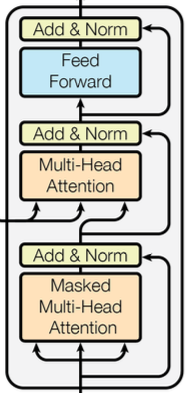

In [28]:
Image(filename = 'block.png', width=125)

In [29]:
# SOURCE: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

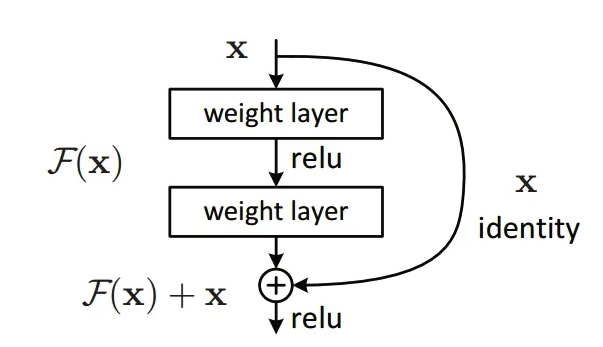

In [30]:
Image(filename = 'residual-blocks.png', width=300)

## Understanding Residual Connections in the GPT Model

When building deep neural networks like our GPT model, we can run into problems because deep networks are harder to train effectively. One powerful solution is using residual connections. Think of a residual connection as a shortcut path for information to flow through the network without getting distorted by too many layers. In our model, the computation flows from top to bottom, and there’s a central pathway called the residual pathway, represented by a black line in diagrams.

At certain points, we “fork off” from this residual pathway to perform some computations—like self-attention or feed-forward processing—and then we add the result back to the main pathway. This is implemented using addition operations. Here’s why this helps: during training, when the network learns by backpropagation, gradients (which update the network’s weights) can flow directly through these addition points. This creates a “gradient superhighway” that allows learning signals to pass unimpeded from the output back to the input layers, making training more efficient.

To implement residual connections in our code, we modify the forward method of the `Block` class like this:
```python
def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x
```

In this code:
* `self.ln1(x)` and `self.ln2(x)` apply layer normalization to stabilize the inputs.
* `self.sa` is the multi-head self-attention operation.
* `self.ffwd` is the feed-forward neural network.
* We add the output of these operations back to the original input `x`, creating the residual connections.

In the `MultiHeadAttention` class, we need to make sure the output dimensions match so we can add them back to `x`. We do this by introducing a projection layer:
```python
self.proj = nn.Linear(n_embd, n_embd)
```

After combining the outputs of all attention heads:
```python
out = torch.cat([h(x) for h in self.heads], dim=-1)
out = self.proj(out)
return out
```

* We concatenate the outputs from all heads along the last dimension.
* We then project this combined output back to the original embedding size (`n_embd`) using `self.proj(out)`.

Similarly, in the `FeedForward` class, we adjust the network to have a larger inner layer, which increases its capacity to learn complex patterns:
```python
self.net = nn.Sequential(
    nn.Linear(n_embd, 4 * n_embd),
    nn.ReLU(),
    nn.Linear(4 * n_embd, n_embd),
)
```

* The first linear layer expands the size from `n_embd` to `4 * n_embd`.
* After applying the ReLU activation function, the second linear layer brings it back to `n_embd`, allowing us to add it back to `x`.

By using these residual connections and appropriately sized projection layers, we allow the model to add new computations without losing the original information. This helps the gradients flow smoothly during training, making it much easier to optimize deep networks like our GPT model.

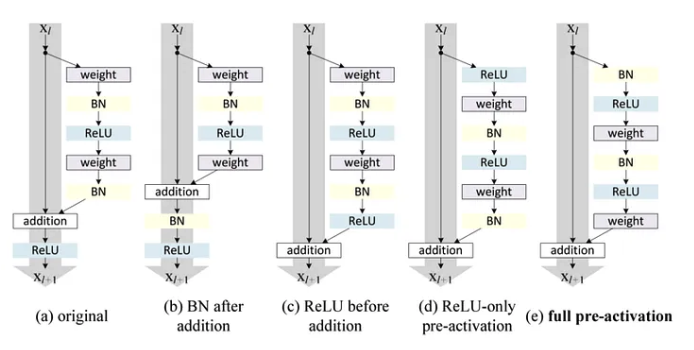

In [31]:
Image(filename = 'types-of-residual-blocks.png', width=500)

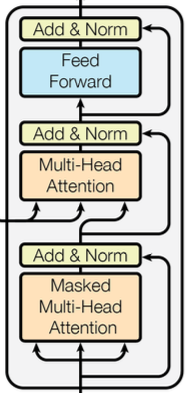

In [32]:
Image(filename = 'block.png', width=125)

## Understanding Layer Normalization in Deep Neural Networks

As our GPT model becomes deeper, we encounter difficulties in training it effectively. Deep neural networks can suffer from optimization issues, making it hard for the model to learn from the data. To overcome this, we use two important techniques from the **“Attention Is All You Need”** paper. We’ve already added residual connections to help information flow through the network. The second optimization is called layer normalization, often shown as “Norm” next to the “Add” operations in diagrams.

Layer normalization is similar to batch normalization, which you might have heard of. In batch normalization, we ensure that each neuron’s output has a mean of zero and a standard deviation of one across the entire batch of data (`B`). This helps stabilize the learning process by keeping the outputs of neurons on a similar scale.

However, layer normalization works a bit differently. Instead of normalizing across the batch, layer normalization normalizes across the features (the elements within each data point). This means that for each individual example in the batch, we compute the mean and variance of its features and adjust them so that they have a mean of zero and a standard deviation of one. This is especially helpful in models like Transformers because it doesn’t depend on the batch size and works well with variable-length sequences.

Here’s how we incorporate layer normalization into our `Block` class:
```python
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.ln1 = nn.LayerNorm(n_embd)  # layer normalization before self-attention
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln2 = nn.LayerNorm(n_embd)  # layer normalization before feed-forward network
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))     # residual connection with self-attention
        x = x + self.ffwd(self.ln2(x))   # residual connection with feed-forward network
        return x
```

In this code:
* Layer Normalization Layers: We introduce `self.ln1` and `self.ln2` using `nn.LayerNorm(n_embd)`. These layers normalize the inputs to the self-attention and feed-forward networks.
* Residual Connections: We maintain our residual connections by adding the output of the self-attention and feed-forward networks back to the original input `x`.
* Forward Method: In the `forward` method, we apply layer normalization before each main operation. This helps stabilize the inputs to those layers.

By using layer normalization, we ensure that the activations (outputs of each layer) have consistent statistics throughout the network. This makes the deep network easier to train because it reduces the internal changes that the network has to adapt to during learning. Combined with residual connections, layer normalization greatly improves the optimization of very deep neural networks like our GPT model.

In [33]:
# SOURCE: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

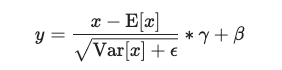

In [34]:
Image(filename = 'layer-norm-formula.png', width=225)

In [35]:
class LayerNorm1d: # (used to be BatchNorm1d)
    """Implements 1D Layer Normalization to stabilize and normalize input activations."""
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

## Understanding How Layer Normalization Works in Our GPT Mode

In our GPT model, we use layer normalization to help stabilize and improve the training of our deep neural network. Let’s consider an example where we have a `batch_size` of 32, and each input vector has 100 dimensions. This means we have 32 samples (vectors), each with 100 features.

When we pass these vectors through a layer normalization layer, we ensure that each feature within a sample is normalized. Specifically, for each individual sample in the batch, we compute the mean and standard deviation across its features and adjust them to have a mean of zero and a standard deviation of one.

Here’s how we implement layer normalization:
```python
# x has a shape of (batch_size, num_features), e.g., (32, 100)
xmean = x.mean(1, keepdim=True)  # compute the mean across features for each sample
xvar = x.var(1, keepdim=True)    # compute the variance across features for each sample
x_normalized = (x - xmean) / torch.sqrt(xvar + 1e-5)  # normalize each sample
```

In this code:
* `xmean` is calculated by taking the mean of `x` across dimension 1, which corresponds to the feature dimension. We use `keepdim=True` to maintain the dimensionality for broadcasting.
* `xvar` is the variance computed similarly across the features of each sample.
* `x_normalized` is the result of subtracting the mean and dividing by the standard deviation (square root of variance plus a small epsilon to prevent division by zero).

By changing the dimension from 0 to 1 in the `mean` and `var` functions, we’re computing the statistics across the features of each individual sample rather than across the batch. This means we’re normalizing each sample independently, and the normalization does not depend on other samples in the batch.

Initially, if we had used:
```python
xmean = x.mean(0, keepdim=True)  # mean across the batch for each feature
xvar = x.var(0, keepdim=True)    # variance across the batch for each feature
```

This would have computed the mean and variance across the batch dimension for each feature (column). In this case, we would be normalizing each feature across all samples in the batch, which is what batch normalization does.

However, since we’re implementing layer normalization, we use:
```python
xmean = x.mean(1, keepdim=True)  # mean across features for each sample
xvar = x.var(1, keepdim=True)    # variance across features for each sample
```

With layer normalization, the columns (features) are not normalized across the batch. Instead, each sample’s features are normalized based on that sample’s own mean and variance. This ensures that the normalization is independent of the batch size and the data in other samples.

By normalizing each sample individually, we help the model to perform consistently regardless of the batch composition, which is particularly useful in models like Transformers where sequences can have varying lengths, and batching can be complex.

In summary, layer normalization adjusts the activations (outputs) of each sample so that they have a mean of zero and a standard deviation of one across their features. This helps the network learn more effectively by preventing internal covariate shift and ensuring that the scale of the inputs to each layer remains consistent.

In [36]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [37]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-3.5763e-09), tensor(1.0000))

## Understanding the Pre-Norm Formulation in Transformer Models

In the original Transformer model described in the **“Attention Is All You Need”** paper, the **Add & Norm** (addition and layer normalization) steps are applied after the main transformations like self-attention and feed-forward networks. However, in more recent implementations, it’s common to apply layer normalization before these transformations. This approach is called the **Pre-Norm Formulation**.

Applying layer normalization before the transformations helps stabilize the training of deep neural networks. It ensures that the inputs to each layer have a consistent scale and distribution, which makes it easier for the network to learn effectively.

In our `Block` class, which represents a single Transformer block, we implement this by adding two layer normalization layers in the constructor:
```python
self.ln1 = nn.LayerNorm(n_embd)  # first layer norm for self-attention
self.ln2 = nn.LayerNorm(n_embd)  # second layer norm for feed-forward network
```

Here, `n_embd` is the embedding dimension—the size of the vector that represents each token (like a word or character) in our sequence.

In the `forward` method of the `Block` class, we apply the layer norms before passing the data to the self-attention and feed-forward layers:
```python
def forward(self, x):
    x = x + self.sa(self.ln1(x))    # apply layer norm before self-attention
    x = x + self.ffwd(self.ln2(x))  # apply layer norm before feed-forward network
    return x
```

By normalizing `x` before each transformation, we help the model learn better and more stable representations. This change reflects modern best practices in training Transformer models, allowing our deep neural network to train more effectively, leading to improved performance in tasks like language modeling.

## Understanding Layer Normalization and Scaling Up Our GPT Model

In our GPT model, we set the embedding size `n_embd` to 32. This means each token in our sequence is represented by a vector of 32 numbers. When we apply layer normalization, we normalize these features by calculating the mean and variance over these 32 numbers for each token. The batch size (`B`) and the sequence length (`T`) act as batch dimensions, so the normalization happens per token independently. This ensures that each token’s features have a mean of zero and a standard deviation of one at initialization.

Layer normalization includes trainable parameters called gamma (γ) and beta (β), which allow the model to scale and shift the normalized outputs during training. In our implementation, we initialize them as follows:
```python
self.gamma = torch.ones(dim)
self.beta = torch.zeros(dim)
```

Here, dim is the embedding dimension (`n_embd`). While the initial output after normalization might be unit Gaussian, the optimization process during training adjusts these parameters to find the best scale and shift for the data.

In the `BigramLanguageModel` class, we add a final layer normalization layer at the end of the Transformer, right before the last linear layer that decodes the embeddings into logits for the vocabulary. This is done in the constructor:
```python
self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
```

To scale up our model and make it more powerful, we introduce the variable `n_layer` in the `BigramLanguageModel` constructor. This variable specifies how many layers of `Block` modules we stack together:
```python
self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
```

Each `Block` consists of multi-head self-attention and a feed-forward neural network, along with residual connections and layer normalization. We also introduce `n_head` which specifies the number of attention heads in our multi-head attention mechanism. By increasing `n_layer` and `n_head`, we can make our model deeper and allow it to capture more complex patterns in the data.

In summary, by properly applying layer normalization and scaling up the model with more layers (`n_layer`) and attention heads (`n_head`), we enhance the model’s ability to learn and generalize from the data. This approach ensures our deep neural network remains stable and effective during training.

### Layer Norm Formula

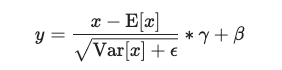

In [38]:
Image(filename = 'layer-norm-formula.png', width=225)

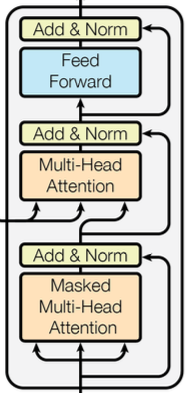

In [39]:
Image(filename = 'block.png', width=125)

## Adding Dropout to Improve the GPT Model

In our GPT model, we introduce a technique called dropout to prevent overfitting and improve the model’s ability to generalize to new data. Dropout works by randomly “turning off” or setting to zero a subset of neurons during each training pass. This means that every time the model processes data during training, it uses a slightly different network configuration. At test time, all neurons are active, and the model benefits from the combined knowledge of these different configurations.

We add dropout layers at specific points in our model to enhance regularization:
1.	In the `FeedForward` class constructor, we add `dropout` right before connecting back to the residual pathway. This ensures that some neurons in the feed-forward network are randomly ignored during training:
```python
self.dropout = nn.Dropout(dropout)
```

2.	In the `MultiHeadAttention` class constructor, we include `dropout` after the attention heads have been processed. This helps prevent the model from becoming too dependent on any single attention pathway:
```python
self.dropout = nn.Dropout(dropout)
```

3. In the `Head` class constructor, we add `dropout` after calculating the attention weights (affinities) and applying the softmax function. This randomly prevents some nodes from communicating, adding a layer of regularization to the attention mechanism:
```python
self.dropout = nn.Dropout(dropout)
```

By incorporating dropout in these areas, we effectively train an ensemble of smaller sub-networks within our larger network. Each sub-network learns slightly different patterns, and when combined, they make the overall model more robust. This technique is especially useful when scaling up models, as it reduces the risk of overfitting to the training data and improves performance on unseen data.

In summary, dropout enhances our GPT model by:
* Randomly disabling neurons during training, which prevents the model from relying too heavily on any single neuron.
* Encouraging the network to learn more generalized features that are useful across different subsets of the data.
* Improving the model’s ability to generalize to new, unseen inputs by reducing overfitting.

This addition ensures that our model remains effective and reliable as it becomes more complex.

### Dropout Layer

In [40]:
# https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

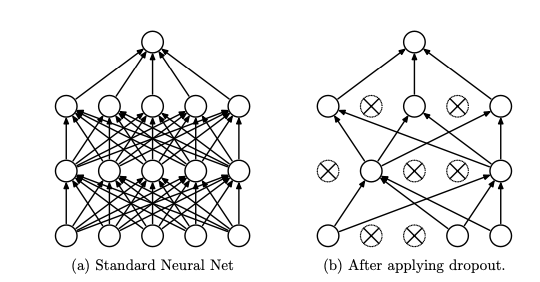

In [41]:
Image(filename = 'dropout.png', width=425)

## Full Finished Code
You may want to refer directly to the git repo instead though.

In [42]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16       # number of independent sequences to process in parallel
block_size = 32       # maximum context length for predictions
max_iters = 5000      # total number of training iterations
eval_interval = 100   # interval for evaluating the model on validation set
learning_rate = 1e-3  # learning rate for the optimizer
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'  # device to run the model on
eval_iters = 200      # number of iterations to estimate loss
n_embd = 64           # embedding dimension
n_head = 4            # number of attention heads
n_layer = 4           # number of transformer blocks
dropout = 0.0         # dropout rate for regularization
# ------------

torch.manual_seed(1337)  # for reproducibility

# load the dataset
# make sure to have 'input.txt' file in your working directory
# you can download it using: wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# create a mapping from characters to integers
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to indices and vice versa
stoi = { ch:i for i,ch in enumerate(chars) }  # string to index
itos = { i:ch for i,ch in enumerate(chars) }  # index to string
encode = lambda s: [stoi[c] for c in s]       # encoder: string to list of integers
decode = lambda l: ''.join([itos[i] for i in l])  # decoder: list of integers to string

# prepare the dataset
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))  # split 90% for training, 10% for validation
train_data = data[:n]
val_data = data[n:]


# function to generate a batch of data
def get_batch(split):
    """
    Generate a batch of input and target sequences for training.

    Args:
        split (str): 'train' or 'val' to select the dataset split.

    Returns:
        x (torch.Tensor): Input tensor of shape (batch_size, block_size).
        y (torch.Tensor): Target tensor of shape (batch_size, block_size).
    """
    # select the appropriate data split
    data = train_data if split == 'train' else val_data
    # randomly choose starting indices for each sequence in the batch
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # collect sequences of length 'block_size' starting from each index
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    # move data to the appropriate device
    x, y = x.to(device), y.to(device)
    return x, y


# function to estimate the loss on training and validation sets
@torch.no_grad()
def estimate_loss():
    """
    Estimate the average loss over several iterations for both
    training and validation datasets.

    Returns:
        out (dict): Dictionary containing average losses for 'train' and 'val'.
    """
    out = {}
    model.eval()  # set the model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)          # get a batch of data
            logits, loss = model(X, Y)       # forward pass
            losses[k] = loss.item()          # store the loss
        out[split] = losses.mean()           # compute the average loss
    model.train()  # set the model back to training mode
    return out


class Head(nn.Module):
    """One head of self-attention."""

    def __init__(self, head_size):
        """
        Initialize the self-attention head.

        Args:
            head_size (int): Dimensionality of the key, query, and value vectors.
        """
        super().__init__()
        # linear projections for keys, queries, and values
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # register a lower triangular matrix for masking future positions
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Perform the forward pass of the self-attention head.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, C).

        Returns:
            out (torch.Tensor): Output tensor of shape (B, T, head_size).
        """
        B, T, C = x.shape
        # compute keys, queries, and values
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        v = self.value(x) # (B, T, head_size)

        # compute attention scores using scaled dot-product
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, T)
        # apply causal mask to prevent attending to future positions
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        # convert scores to probabilities
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)       # apply dropout

        # compute the weighted sum of values
        out = wei @ v  # (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):
    """Multiple self-attention heads in parallel."""

    def __init__(self, num_heads, head_size):
        """
        Initialize the multi-head attention module.

        Args:
            num_heads (int): Number of attention heads.
            head_size (int): Size of each head.
        """
        super().__init__()
        # create a list of attention heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # linear projection to combine the outputs of all heads
        self.proj = nn.Linear(n_embd, n_embd)
        # dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Perform the forward pass of multi-head attention.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, C).

        Returns:
            out (torch.Tensor): Output tensor of shape (B, T, C).
        """
        # concatenate the outputs from all attention heads
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # (B, T, C)
        # apply linear projection and dropout
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """A simple feed-forward neural network."""

    def __init__(self, n_embd):
        """
        Initialize the feed-forward network.

        Args:
            n_embd (int): Embedding dimension.
        """
        super().__init__()
        # define a two-layer MLP
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # expand dimensionality
            nn.ReLU(),                      # non-linearity
            nn.Linear(4 * n_embd, n_embd),  # project back to original size
            nn.Dropout(dropout),            # dropout for regularization
        )

    def forward(self, x):
        """
        Perform the forward pass of the feed-forward network.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, C).

        Returns:
            torch.Tensor: Output tensor of the same shape.
        """
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication followed by computation."""

    def __init__(self, n_embd, n_head):
        """
        Initialize the transformer block.

        Args:
            n_embd (int): Embedding dimension.
            n_head (int): Number of attention heads.
        """
        super().__init__()
        head_size = n_embd // n_head  # size of each attention head
        # multi-head self-attention
        self.sa = MultiHeadAttention(n_head, head_size)
        # feed-forward network
        self.ffwd = FeedForward(n_embd)
        # layer normalizations
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        """
        Perform the forward pass of the transformer block.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, C).

        Returns:
            torch.Tensor: Output tensor of the same shape.
        """
        # apply layer norm and self-attention, then add residual connection
        x = x + self.sa(self.ln1(x))
        # apply layer norm and feed-forward network, then add residual connection
        x = x + self.ffwd(self.ln2(x))
        return x


class BigramLanguageModel(nn.Module):
    """Language model based on the Transformer architecture."""

    def __init__(self):
        """
        Initialize the language model.

        The model consists of token embeddings, positional embeddings,
        multiple transformer blocks, and a final linear layer to produce logits.
        """
        super().__init__()
        # token embedding table: maps token indices to embedding vectors
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # positional embedding table: learns embeddings for positions in the sequence
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # stack of transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # final layer normalization
        self.ln_f = nn.LayerNorm(n_embd)
        # linear layer to project embeddings to vocabulary logits
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        """
        Perform the forward pass of the language model.

        Args:
            idx (torch.Tensor): Input tensor of token indices with shape (B, T).
            targets (torch.Tensor, optional): Target tensor for computing loss.

        Returns:
            logits (torch.Tensor): Logits tensor of shape (B, T, vocab_size).
            loss (torch.Tensor or None): Cross-entropy loss if targets are provided.
        """
        B, T = idx.shape

        # get token embeddings for each token in the sequence
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        # get positional embeddings for each position in the sequence
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T, C)
        # add token and positional embeddings to get the input to transformer blocks
        x = tok_emb + pos_emb  # (B, T, C)
        # pass through the stack of transformer blocks
        x = self.blocks(x)     # (B, T, C)
        # apply final layer normalization
        x = self.ln_f(x)       # (B, T, C)
        # compute logits for the next token prediction
        logits = self.lm_head(x)  # (B, T, vocab_size)

        # if targets are provided, compute the loss
        if targets is None:
            loss = None
        else:
            # reshape logits and targets for computing cross-entropy loss
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # compute the loss
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """
        Generate new text by sampling from the language model.

        Args:
            idx (torch.Tensor): Input tensor of shape (B, T) containing the context.
            max_new_tokens (int): Number of new tokens to generate.

        Returns:
            idx (torch.Tensor): Tensor of shape (B, T + max_new_tokens) with generated tokens.
        """
        for _ in range(max_new_tokens):
            # ensure the context does not exceed the block size
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, _ = self(idx_cond)
            # focus on the last time step
            logits = logits[:, -1, :]  # (B, vocab_size)
            # convert logits to probabilities
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            # sample the next token from the probability distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append the new token to the sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


# instantiate the model and move it to the appropriate device
model = BigramLanguageModel().to(device)
# print the number of parameters (in millions)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create an optimizer for updating the model parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# training loop
for iter in range(max_iters):

    # every eval_interval iterations, evaluate the model on the validation set
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # get a batch of training data
    xb, yb = get_batch('train')

    # compute the loss and gradients
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate text from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)  # starting token (e.g., <SOS>)
generated_sequence = model.generate(context, max_new_tokens=2000)[0].tolist()
# decode and print the generated text
print(decode(generated_sequence))

0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5091, val loss 2.5060
step 300: train loss 2.4196, val loss 2.4336
step 400: train loss 2.3503, val loss 2.3565
step 500: train loss 2.2965, val loss 2.3127
step 600: train loss 2.2410, val loss 2.2501
step 700: train loss 2.2048, val loss 2.2186
step 800: train loss 2.1636, val loss 2.1864
step 900: train loss 2.1242, val loss 2.1504
step 1000: train loss 2.1024, val loss 2.1291
step 1100: train loss 2.0690, val loss 2.1176
step 1200: train loss 2.0377, val loss 2.0795
step 1300: train loss 2.0229, val loss 2.0622
step 1400: train loss 1.9922, val loss 2.0357
step 1500: train loss 1.9706, val loss 2.0315
step 1600: train loss 1.9618, val loss 2.0465
step 1700: train loss 1.9409, val loss 2.0130
step 1800: train loss 1.9077, val loss 1.9936
step 1900: train loss 1.9078, val loss 1.9855
step 2000: train loss 1.8825, val loss 1.9938
step 2100: train loss 1.